In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip drive/MyDrive/brain.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [5]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import backend as k
from tensorflow.keras.optimizers import  SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import keras

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] =[16,10]
plt.rcParams ['font.size'] = 16
from sklearn.model_selection import StratifiedKFold
from mpl_toolkits.axes_grid1 import ImageGrid

In [6]:
SAMPLE_PER_CATEGORIES = 200
SEED =42
WIDTH = 150
HEIGHT =150
DEPTH = 3

INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

In [7]:
data_dir= ("/content")
data_dir = ("/content")
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")

In [8]:
CATEGORIES =["glioma", "meningioma", "notumor", "pituitary"]
NUM_OF_CATEGORIES = len(CATEGORIES)
NUM_OF_CATEGORIES

4

In [9]:
for category in CATEGORIES:
    print('{} {} images'.format(category,len(os.listdir(os.path.join(train_dir, category)))))

glioma 1321 images
meningioma 1339 images
notumor 1595 images
pituitary 1457 images


In [10]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(test_dir, category)))))

glioma 300 images
meningioma 306 images
notumor 405 images
pituitary 300 images


In [11]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [12]:
train=[]
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['Training/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns = ['file', 'category_id', 'category'])
train.shape

(5712, 3)

In [13]:
train.head(3)

,file,category_id,category
0,Training/glioma/Tr-gl_0785.jpg,0,glioma
1,Training/glioma/Tr-gl_0983.jpg,0,glioma
2,Training/glioma/Tr-gl_0718.jpg,0,glioma


In [14]:
train = pd.concat([train[train['category']==c][:SAMPLE_PER_CATEGORIES] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.shape

(800, 3)

In [15]:
train.head()

,file,category_id,category
0,Training/glioma/Tr-gl_0515.jpg,0,glioma
1,Training/meningioma/Tr-me_0812.jpg,1,meningioma
2,Training/notumor/Tr-no_0838.jpg,2,notumor
3,Training/meningioma/Tr-me_0580.jpg,1,meningioma
4,Training/meningioma/Tr-me_0889.jpg,1,meningioma


In [16]:
test = []
for file in os.listdir(test_dir):
    test.append(['testDatasets/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.shape

(4, 2)

In [17]:
test.head(5)

,filepath,file
0,testDatasets/notumor,notumor
1,testDatasets/meningioma,meningioma
2,testDatasets/glioma,glioma
3,testDatasets/pituitary,pituitary


In [18]:
CATEGORIES

['glioma', 'meningioma', 'notumor', 'pituitary']

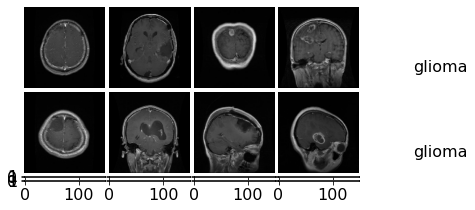

In [35]:
fig = plt.figure(1, figsize=(6,6))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad = 0.05)
i=0
for category_id, category in enumerate({CATEGORIES[0]}):
    for filepath in train[train['category']== category]['file'].values[:8]:
        ax =grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img/255.0)
        ax.axis('off')
        if i % NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1
plt.show()

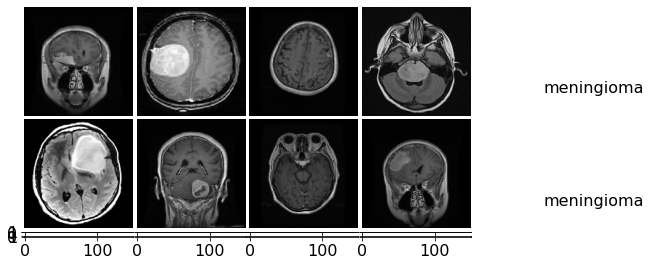

In [34]:
fig = plt.figure(1, figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols = (4,4), axes_pad = 0.05)
i=0
for category_id, category in enumerate({CATEGORIES[1]}):
    for filepath in train[train['category']== category]['file'].values[:8]:
        ax=grid[i]
        img=read_img(filepath, (WIDTH,HEIGHT))
        ax.imshow(img/255.0)
        ax.axis('off')
        if i%NUM_OF_CATEGORIES == NUM_OF_CATEGORIES -1:
                ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1
plt.show()

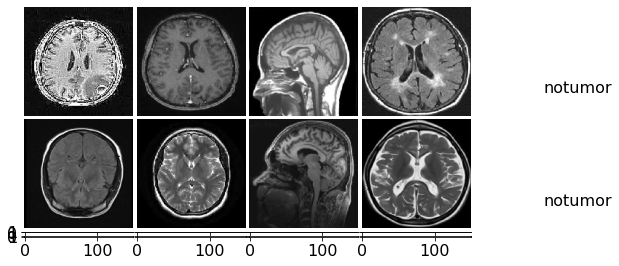

In [37]:
fig = plt.figure(1, figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad = 0.05)
i=0
for category_id, category in enumerate({CATEGORIES[2]}):
    for filepath in train[train['category']== category]['file'].values[:8]:
        ax =grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img/255.0)
        ax.axis('off')
        if i % NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1
plt.show()

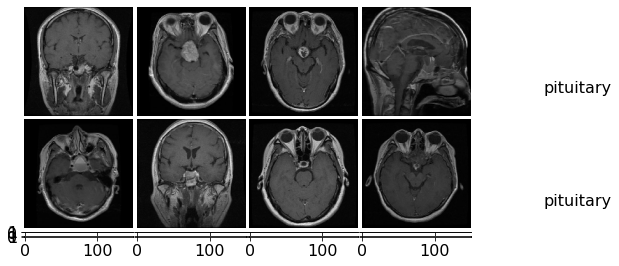

In [36]:
fig = plt.figure(1, figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad = 0.05)
i=0
for category_id, category in enumerate({CATEGORIES[3]}):
    for filepath in train[train['category']== category]['file'].values[:8]:
        ax =grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img/255.0)
        ax.axis('off')
        if i % NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1
plt.show()


In [23]:
12
np.random.seed (seed=SEED)

In [24]:
vgg19 = VGG19(include_top = False, weights= 'imagenet', input_shape = INPUT_SHAPE)                                  
vgg19.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [25]:
def setTrainableLayerVGG(vgg_model):
    set_trainable = False
    for layer in vgg_model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
        
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return vgg_model

In [26]:
vgg19 = VGG19(include_top = False, weights= 'imagenet', input_shape = INPUT_SHAPE)
output = vgg19.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg19.input, output)

vgg_model = setTrainableLayerVGG(vgg_model)

#for purpose of visualization of layer details
pd.set_option('max_colwidth', -1)
layers = [(layer,layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable'])

<ipython-input-26-13de9f4c4348>:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f303534ba30>,input_2,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f30bea40ca0>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f3032218220>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f30285899a0>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f30285e7c70>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f3028590c10>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f30285978b0>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f30285905e0>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f30285a24f0>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f30285a2b50>,block3_conv3,False


In [27]:
resnet50= ResNet50(include_top = False, weights='imagenet', input_shape= INPUT_SHAPE)
resnet50.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [28]:
[(layer.name) for layer in resnet50.layers]


['input_3',
 'conv1_pad',
 'conv1_conv',
 'conv1_bn',
 'conv1_relu',
 'pool1_pad',
 'pool1_pool',
 'conv2_block1_1_conv',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_conv',
 'conv2_block1_2_bn',
 'conv2_block1_2_relu',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block1_0_bn',
 'conv2_block1_3_bn',
 'conv2_block1_add',
 'conv2_block1_out',
 'conv2_block2_1_conv',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_conv',
 'conv2_block2_2_bn',
 'conv2_block2_2_relu',
 'conv2_block2_3_conv',
 'conv2_block2_3_bn',
 'conv2_block2_add',
 'conv2_block2_out',
 'conv2_block3_1_conv',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_conv',
 'conv2_block3_2_bn',
 'conv2_block3_2_relu',
 'conv2_block3_3_conv',
 'conv2_block3_3_bn',
 'conv2_block3_add',
 'conv2_block3_out',
 'conv3_block1_1_conv',
 'conv3_block1_1_bn',
 'conv3_block1_1_relu',
 'conv3_block1_2_conv',
 'conv3_block1_2_bn',
 'conv3_block1_2_relu',
 'conv3_block1_0_conv',
 'conv3_

In [29]:
def setTrainableLayerRnet(resnet_model):
    set_trainable=False
    for layer in resnet_model.layers:
        if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activaton_97']:
            set_trainable=True
        
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return resnet_model

In [30]:
resnet50 = ResNet50(include_top = False, weights ='imagenet', input_shape= INPUT_SHAPE)

output= resnet50.layers[-1].output
output = keras.layers.Flatten()(output)
resnet_model = Model(resnet50.input, output)

setTrainableLayerRnet(resnet_model)

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

<ipython-input-30-adba95ddac82>:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f302846e7c0>,input_4,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f3028476d00>,conv1_pad,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f302b52d670>,conv1_conv,False
3,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3028436580>,conv1_bn,False
4,<keras.layers.core.activation.Activation object at 0x7f302844cfd0>,conv1_relu,False
...,...,...,...
171,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f30282fbcd0>,conv5_block3_3_conv,False
172,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3028370520>,conv5_block3_3_bn,False
173,<keras.layers.merging.add.Add object at 0x7f302835b2e0>,conv5_block3_add,False
174,<keras.layers.core.activation.Activation object at 0x7f30283566a0>,conv5_block3_out,False


In [31]:
def printHistory(history, title, epochs):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    t = f.suptitle(title, fontsize =12)
    f.subplots_adjust(top=0.85, wspace = 0.3)
    
    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label ='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label ='validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc='best')
    
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2= ax2.legend(loc='best')
    
    #return history, title, epochs

In [32]:
def train_ModelIDF(images, pretrainedModel, fineTune, 
                  epochs, batch_size, 
                 learning_rate, cross_validation_folds, 
                  activation, number_of_hidden_layers, optimizer):
    print("Train Model")

    datagen_train = ImageDataGenerator(rescale=1/255.0)
    datagen_valid = ImageDataGenerator(rescale = 1/255.0)
    
    print("Cross Validation")
    kfold = StratifiedKFold(n_splits = cross_validation_folds, shuffle = True)
    cvscores = []
    iteration =1
    
    t=images.category_id
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):
        print("================================================")
        print ("Iteration =", iteration)
        
        iteration = iteration + 1
        
        train = images.loc[train_index]
        test = images.loc[test_index]
        
        print("================================================")
        
        Create_Model = Create_Model(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate,
                            cross_validation_folds, activation, number_of_hidden_layers, optimizer )
        
        print("================================================")
        
        train_generator = datagen_train.flow_from_dataframe(dataframe = train,
                                                           directory="/content/",
                                                           x_col = "file",
                                                           y_col = "category",
                                                           batch_size = batch_size,
                                                           seed = SEED,
                                                           shuffle = True,
                                                           class_mode="categorical",
                                                           target_size = (HEIGHT, WIDTH));
        
        valid_generator = datagen_valid.flow_from_dataframe(dataframe=test,
                                                           directory="/content/",
                                                           x_col = "file",
                                                           y_col = "category",
                                                           batch_size = batch_size,
                                                           seed = SEED,
                                                           shuffle = False,
                                                           class_mode = "categorical",
                                                           target_size = (HEIGHT, WIDTH));
        
        STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
        
        #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit(train_generator,\
                           validation_data = valid_generator, \
                           steps_per_epoch = STEP_SIZE_TRAIN, \
                           validation_steps = STEP_SIZE_VALID, \
                           epochs = epochs, \
                           verbose=1)#, \
                            #callbacks = get_callbacks(patience=2))
                            
        scores = model.evaluate(valid_generator, steps=STEP_SIZE_VALID)   
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1]*100)
        
        printHistory(history, pretrainedModel, epochs)
        
    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%%(+/- %.2f%%)" % (accuracy,std))
    return accuracy, std

In [33]:
train_ModelIDF='train', 
pretrainedModel='vgg19',
fineTune = False,
batch_size=32,
#createModel="none",
cross_validation_folds =2,
learning_rate=0.001,
activation='relu',
number_of_hidden_layers = 2,
optimizer = 'Adam',
epochs=5